In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import powerlaw
import scipy.stats as st
import os

In [2]:
df = pd.read_parquet('../Outputs/cleaned-5-player-features-3d-halves.parquet')
all_maps = df['mapName'].unique()
df.head()

,matchID,mapName,side,team,p1_name,p2_name,p3_name,p4_name,p5_name,p1_ch_area,...,p5_C1,p5_C2,p5_C3,p5_C4,p5_C5,p5_alpha_d,p5_num_samples_d,p5_num_samples_j,p5_alpha_j,Label
0,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,CT,Ninjas in Pyjamas,Plopski,REZ,es3tag,hampus,phzy,1.432302e+07,...,7.721726e-15,2725.847382,64.140451,0.758999,1152.264747,0.185044,569.0,1792.0,0.251674,de_inferno_CT
1,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,T,G2 Esports,AmaNEk,JACKZ,NiKo,huNter-,kennyS,2.208576e+07,...,8.020956e-16,1190.073588,36.306674,0.494552,1016.670393,0.169220,342.0,1716.0,0.309717,de_inferno_T
2,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,CT,Endpoint.CeX,CRUC1AL,MiGHTYMAX,Surreal,Thomas,mirbit,1.235731e+07,...,2.980676e-23,1721.200206,27.449853,1.270701,876.166661,0.208342,370.0,1431.0,0.391351,de_ancient_CT
3,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,T,SINNERS Esports,NEOFRAG,SHOCK,ZEDKO,beastik,oskar,2.067009e+07,...,9.701457e-18,3525.378264,56.117520,0.634490,1285.330550,0.200930,524.0,2130.0,0.323994,de_ancient_T
4,0657c9fd-a475-4257-8879-265fdbfd59b0,de_mirage,CT,Natus Vincere,Boombl4,Perfecto,b1t,electronic,s1mple,8.731215e+06,...,7.490980e-16,1050.978072,40.402006,1.750768,1332.421537,0.127130,376.0,2386.0,0.444738,de_mirage_CT


In [3]:
# Extract the metric names (excluding prefixes like p1_, p2_, etc.)
metrics = [
    'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed',
    'frac_dim',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'alpha_d', 'alpha_j', 'num_samples_d','num_samples_j'
]

# Statistic suffixes
stats = ['min', 'max', 'mean',  'std']

# List comprehension for output column names
output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

# Iterate through each metric and calculate row-wise stats
for metric in metrics:
    cols = [f'p{i+1}_{metric}' for i in range(5)]

    # Convert to a 2D array for row-wise operation
    data = df[cols].to_numpy()

    # Add new columns with row-wise aggregations
    df[f'{metric}_min'] = np.min(data, axis=1)
    df[f'{metric}_max'] = np.max(data, axis=1)
    df[f'{metric}_mean'] = np.mean(data, axis=1)
    df[f'{metric}_std'] = np.std(data, axis=1)

In [4]:
aggregate_df = df[['matchID', 'mapName', 'side', 'team', 'Label'] + output_columns]
aggregate_df.Label.value_counts()

Label
de_mirage_CT      130
de_mirage_T       130
de_inferno_CT     124
de_inferno_T      124
de_nuke_T         116
de_nuke_CT        115
de_ancient_CT      83
de_ancient_T       83
de_vertigo_CT      77
de_vertigo_T       77
de_overpass_CT     75
de_overpass_T      75
de_dust2_CT        75
de_dust2_T         75
Name: count, dtype: int64

In [5]:
# Note for 0 < a < 1 increasing alpha leads to a slower decay (higher probability of longer duration dwell/journey)
# Pick rate (see link below) seems to show players prefer maps where long dwells are less common and long journeys are less common (faster paced maps)
# https://www.hltv.org/stats/maps?startDate=2022-01-01&endDate=2022-12-31&rankingFilter=Top50

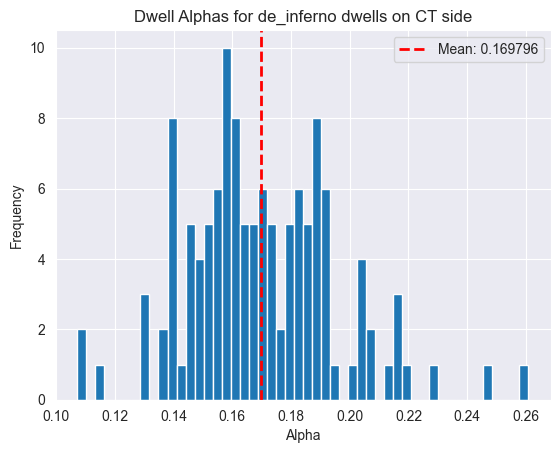

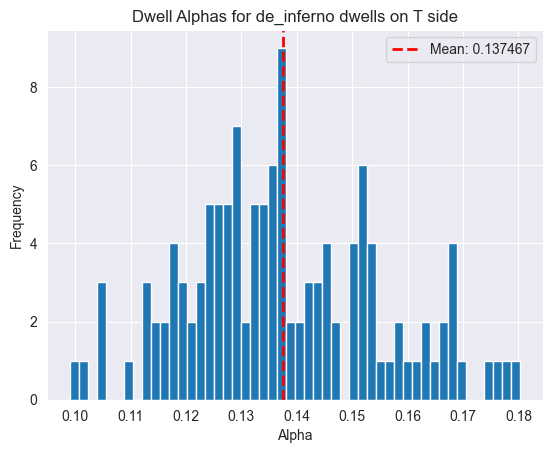

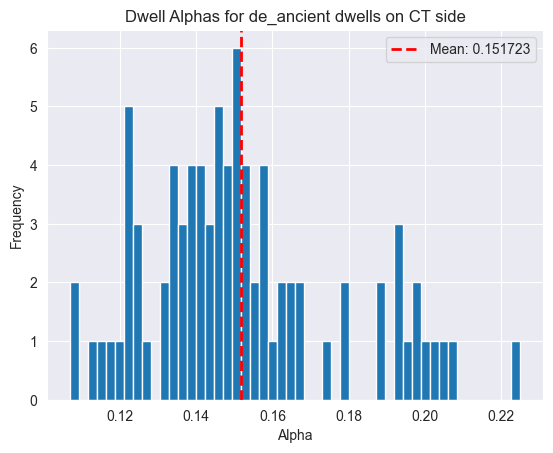

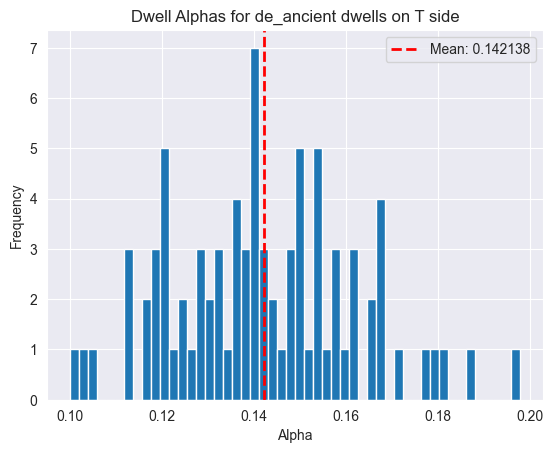

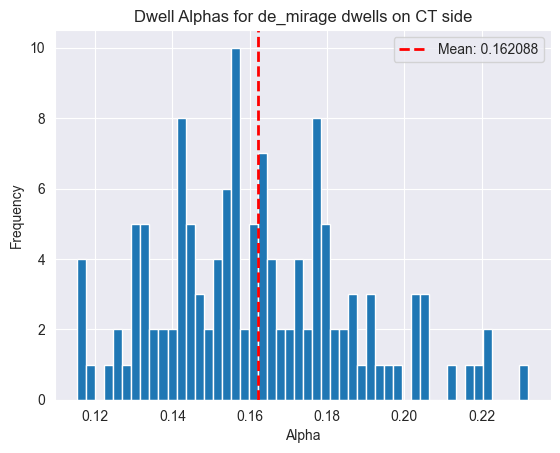

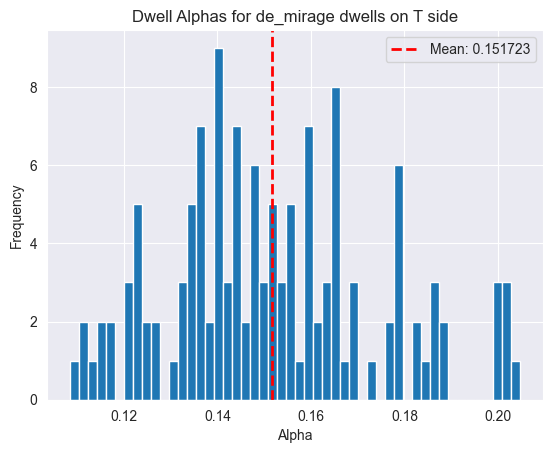

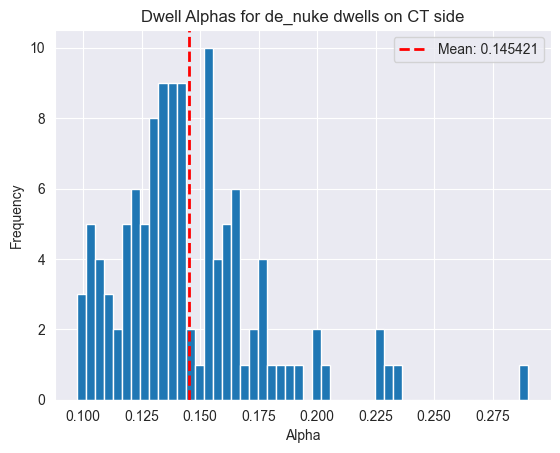

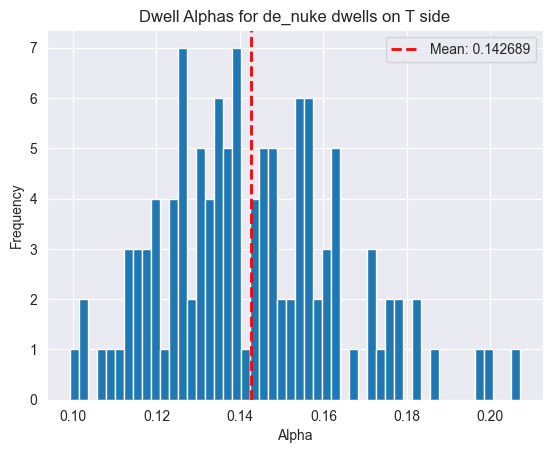

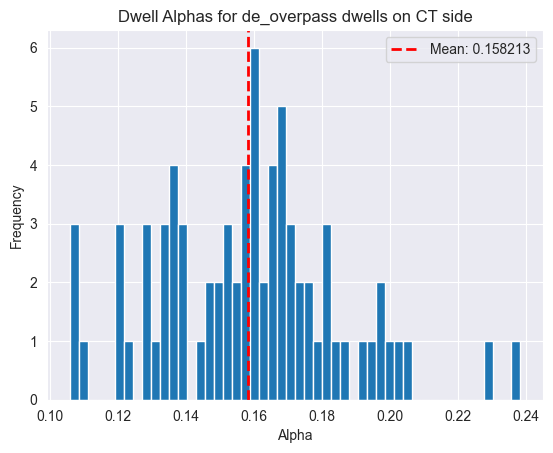

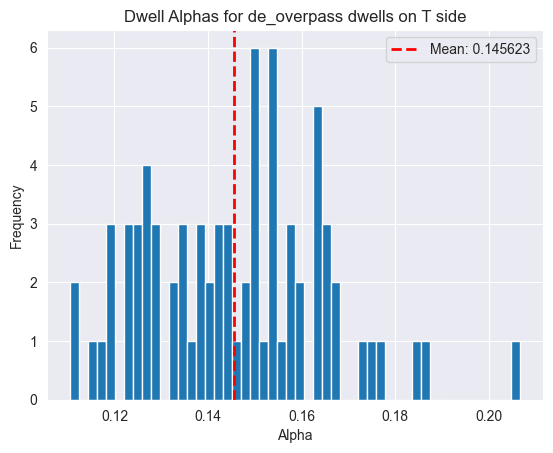

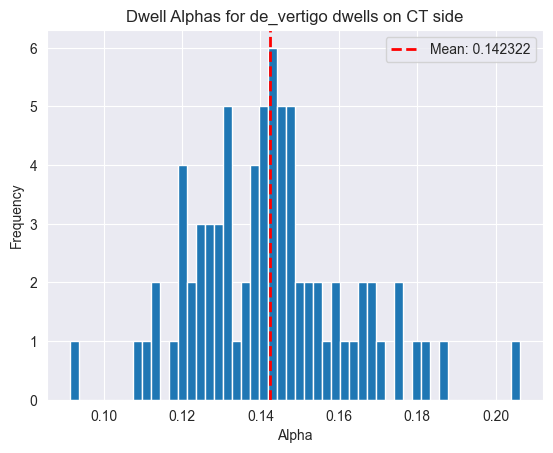

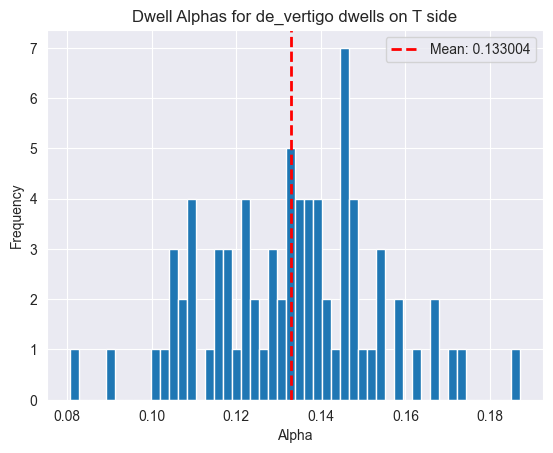

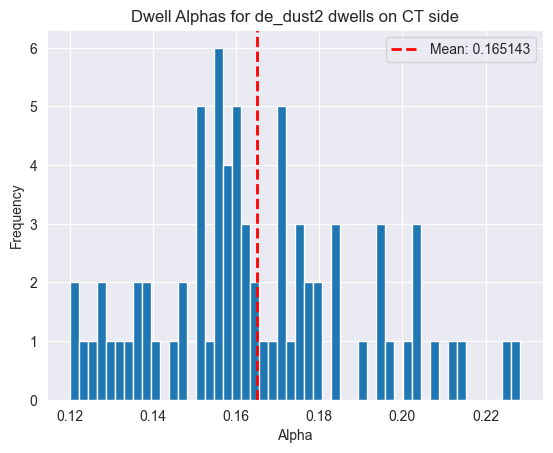

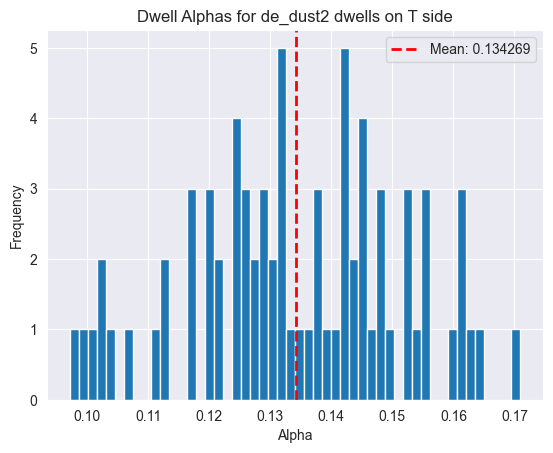

In [6]:
for map_name in all_maps:
    for s in aggregate_df.side.unique():
        plt.figure()  # Create a new figure for each histogram
        filtered_data = aggregate_df.loc[(aggregate_df['mapName'] == map_name) & (aggregate_df['side'] == s)]['alpha_d_mean']
        filtered_data = filtered_data[filtered_data <= 1]
        filtered_data.hist(bins=50)
        mean_alpha = filtered_data.mean()
        plt.axvline(mean_alpha, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_alpha:.6f}')
        
        plt.title(f"Dwell Alphas for {map_name} dwells on {s} side")
        plt.xlabel('Alpha')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()  # Display the histogram
    

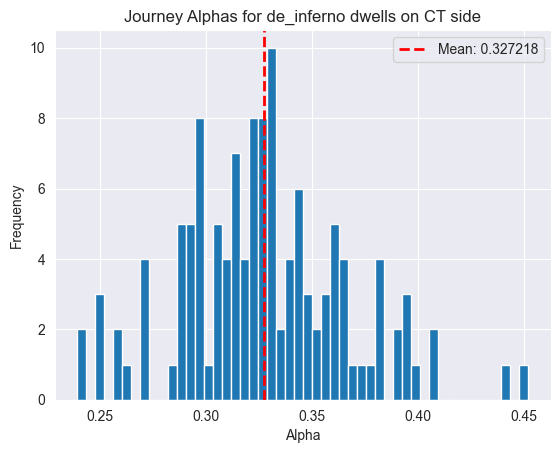

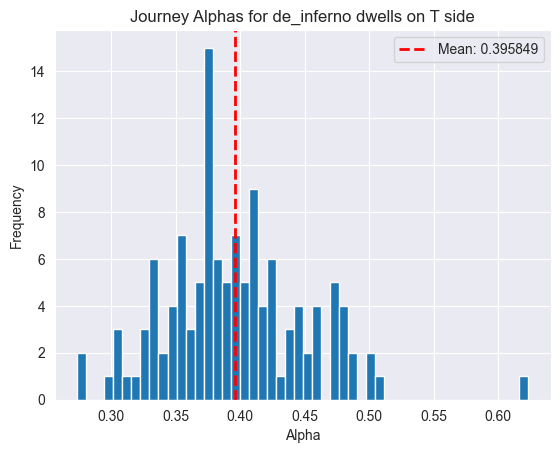

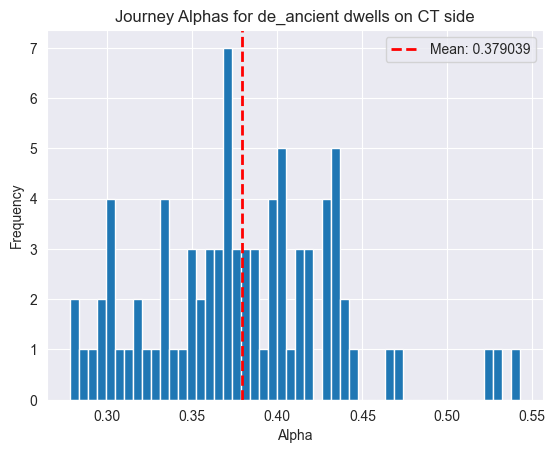

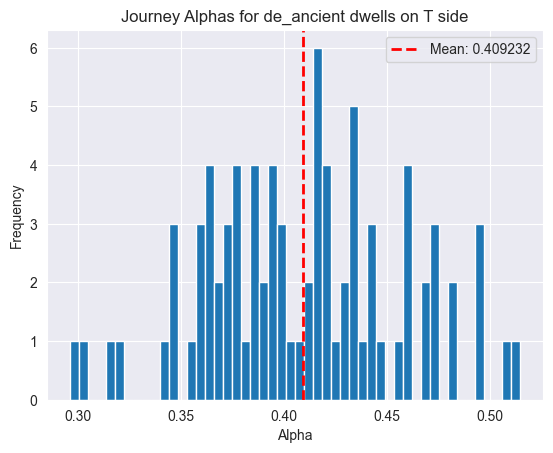

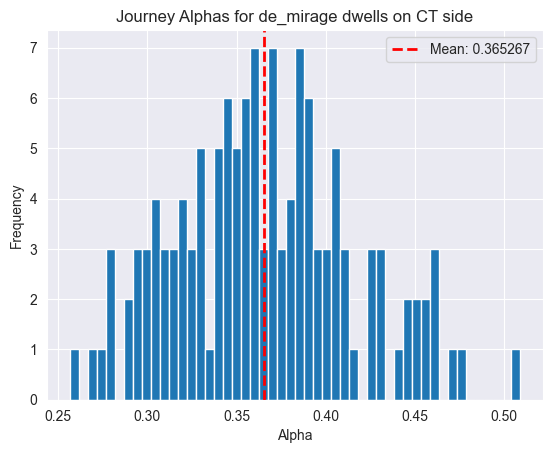

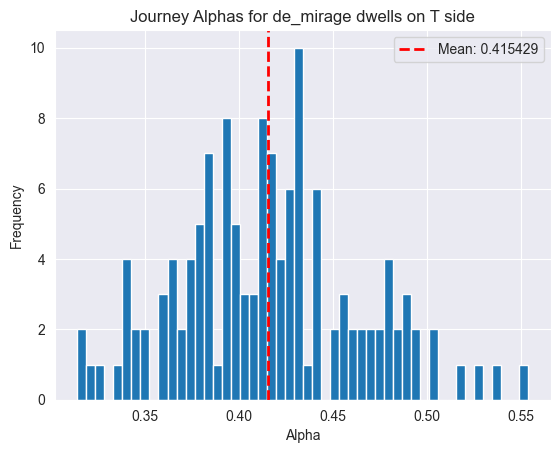

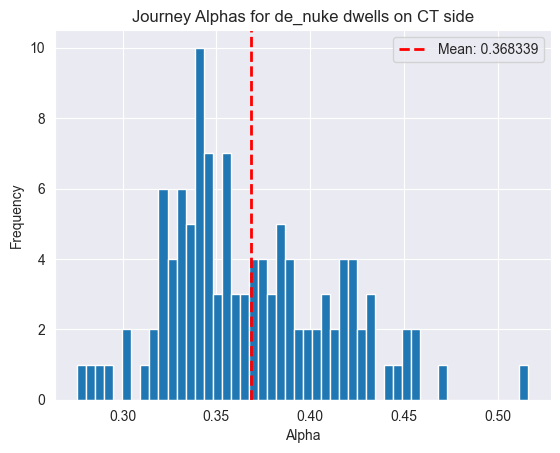

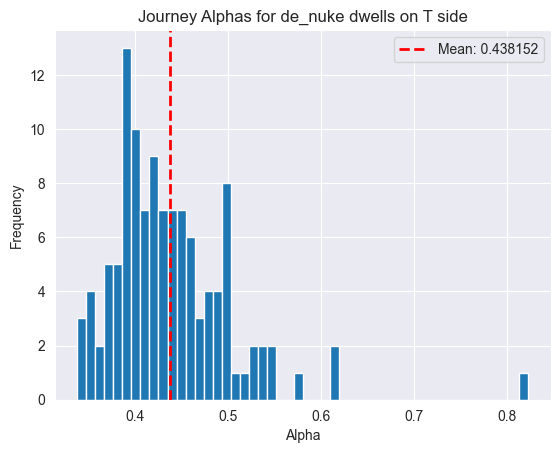

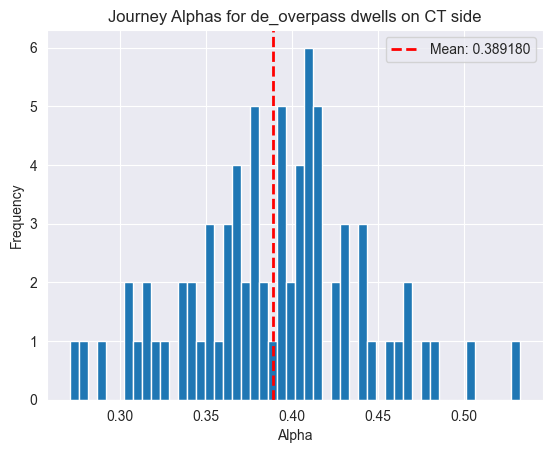

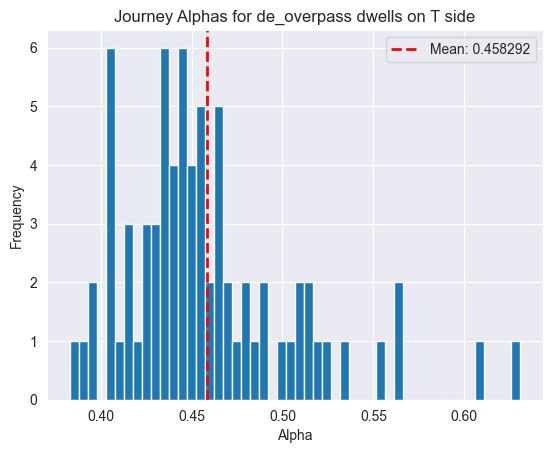

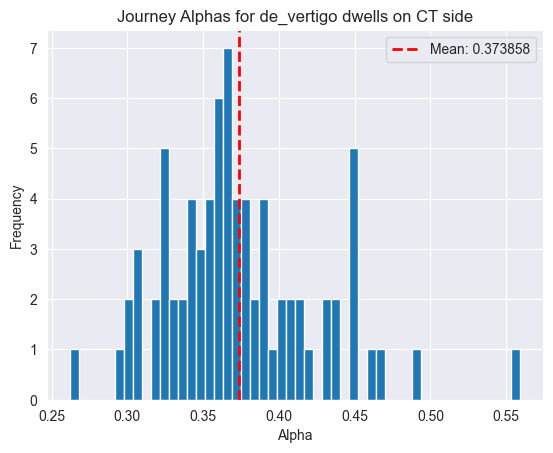

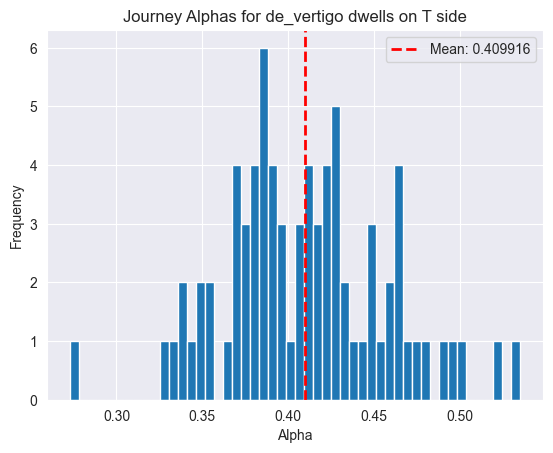

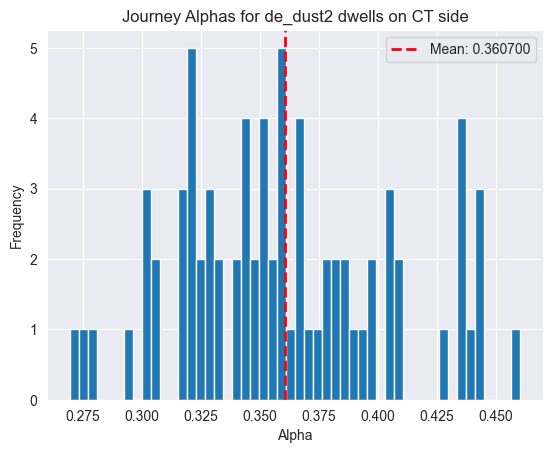

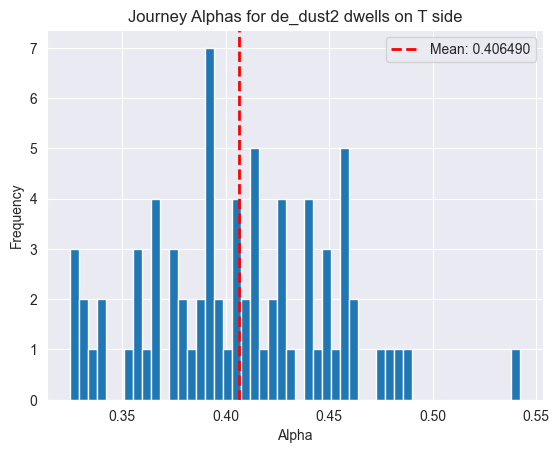

In [7]:
for map_name in all_maps:
    for s in aggregate_df.side.unique():
        plt.figure()  # Create a new figure for each histogram
        filtered_data = aggregate_df.loc[(aggregate_df['mapName'] == map_name) & (aggregate_df['side'] == s)]['alpha_j_mean']
        filtered_data = filtered_data[filtered_data <= 1]
        filtered_data.hist(bins=50)
        mean_alpha = filtered_data.mean()
        plt.axvline(mean_alpha, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_alpha:.6f}')

        plt.title(f"Journey Alphas for {map_name} dwells on {s} side")
        plt.xlabel('Alpha')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()  # Display the histogram

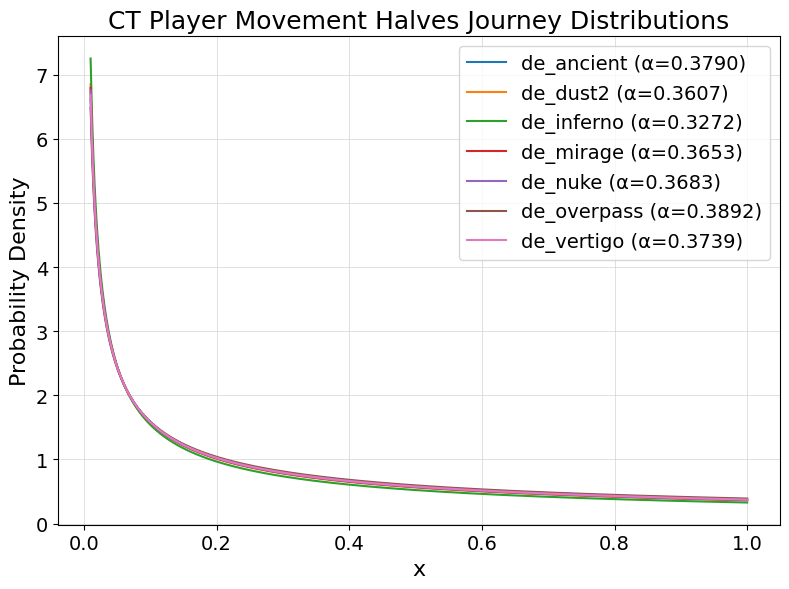

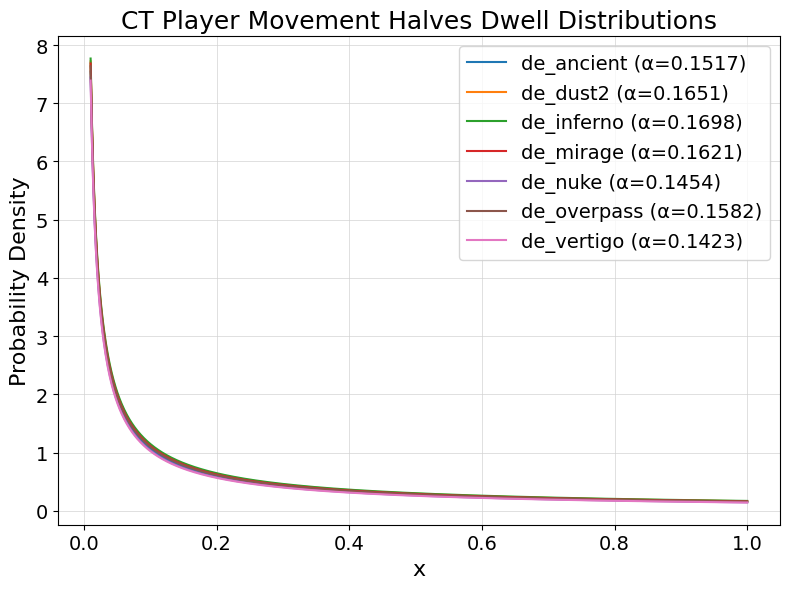

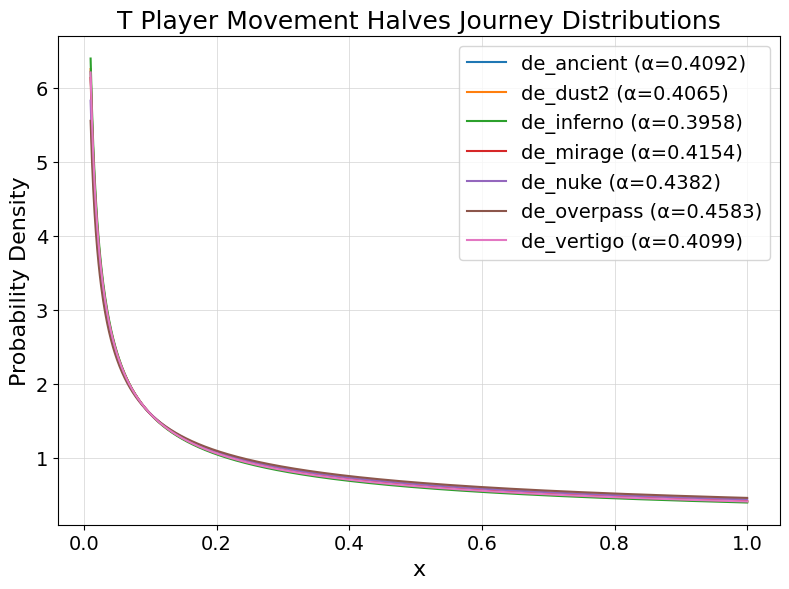

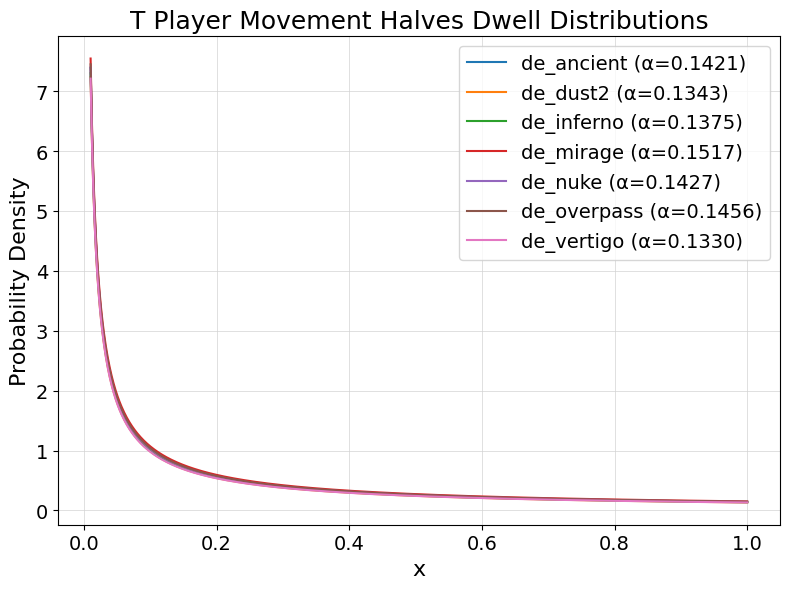

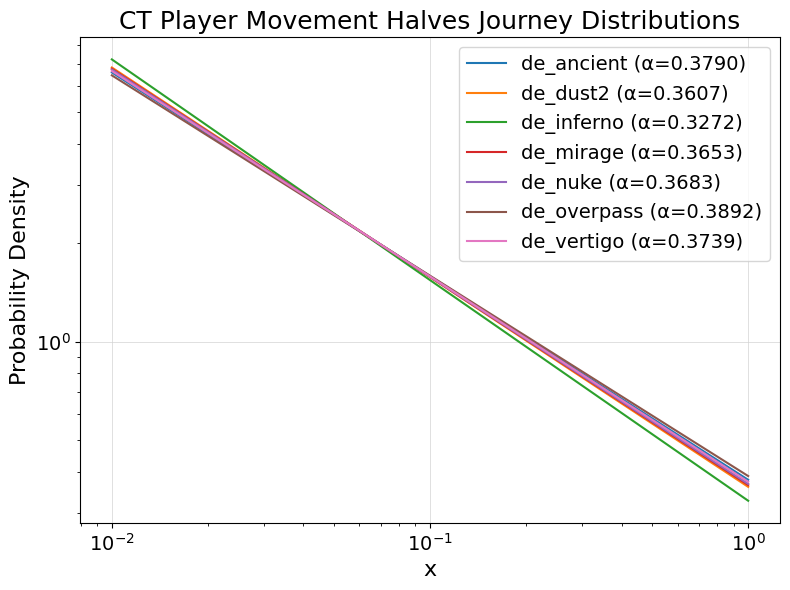

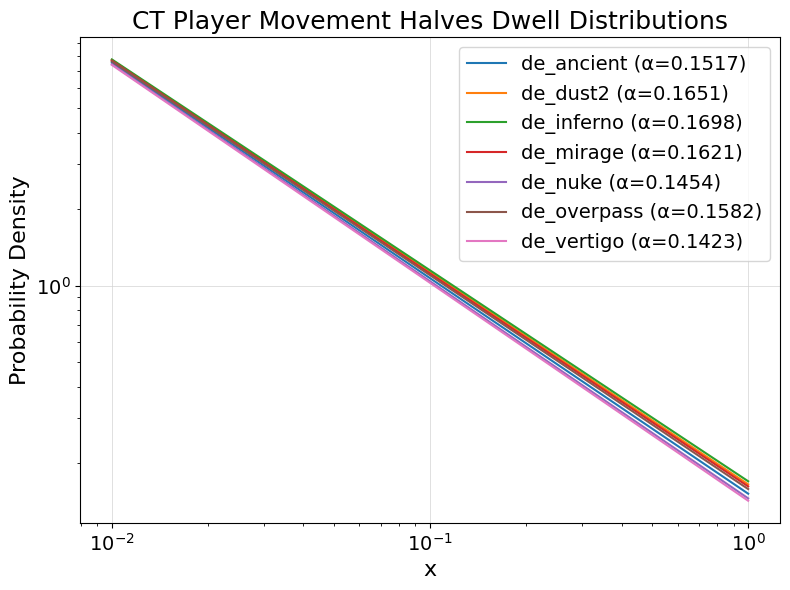

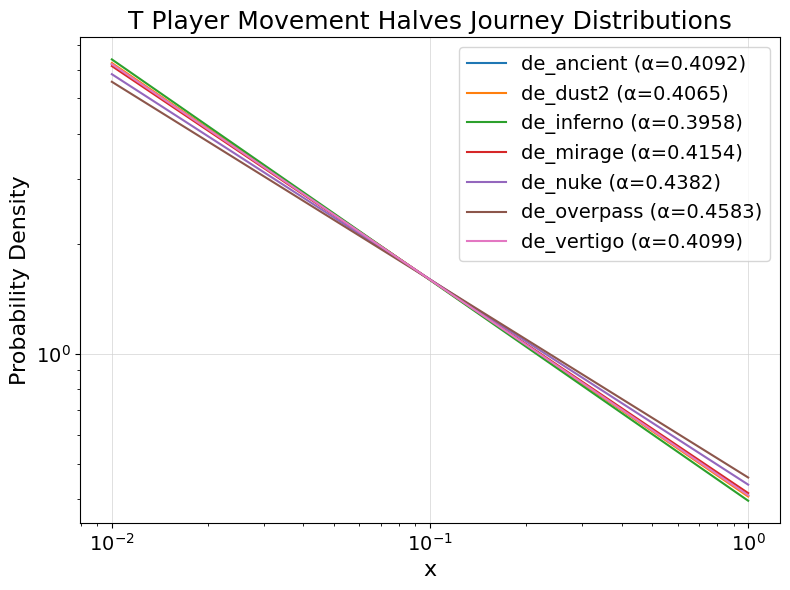

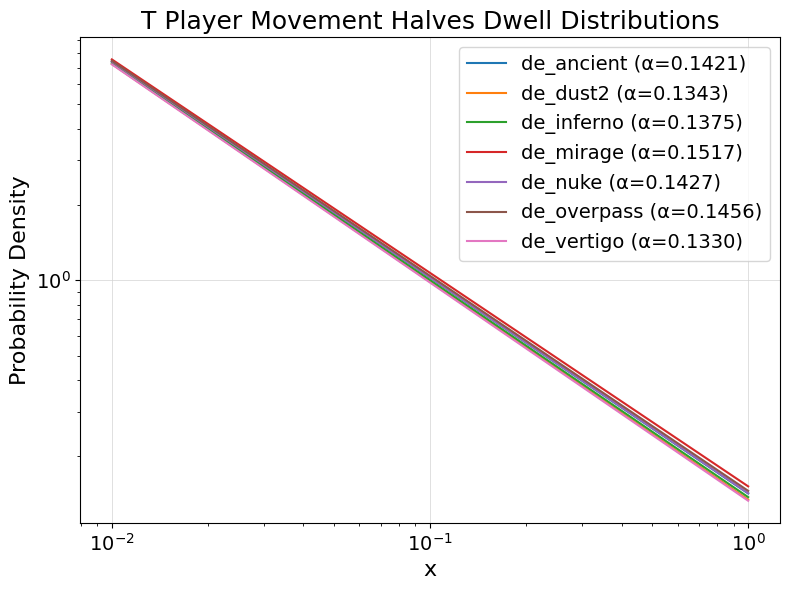

In [20]:
# === Configuration ===
save_figures = True
output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('default')  # Reset to clean style
plt.rcParams.update({
    'axes.facecolor': 'white',    # White plot background
    'figure.facecolor': 'white',  # White figure background
    'grid.color': 'lightgray',    # Light gray grid lines
    'grid.linestyle': '-',        # Solid grid lines
    'grid.linewidth': 0.5,        # Thin grid lines
})


# Font size settings
font_sizes = {
    "title": 18,
    "label": 16,
    "ticks": 14,
    "legend": 14
}

# === Helpers ===
def show_and_save(fig, filename):
    plt.tight_layout()
    if save_figures:
        fig.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()
    plt.close(fig)

# Set x-axis for PDFs
x = np.linspace(0.01, 1, 1000)

# Group by side (CT or T)
for i in [0, 1]:
    for side, side_df in aggregate_df.groupby('side'):

        # --- Plot for journeys ---
        fig = plt.figure(figsize=(8, 6))
        for map_name, map_df in side_df.groupby('mapName'):
            mean_journey_alpha = map_df.loc[map_df.alpha_j_mean <= 1]['alpha_j_mean'].mean()
            rv = powerlaw(a=mean_journey_alpha)
            plt.plot(x, rv.pdf(x), label=f'{map_name} (α={mean_journey_alpha:.4f})')

        plt.title(f'{side} Player Movement Halves Journey Distributions',
                  fontsize=font_sizes["title"])
        plt.xlabel('x', fontsize=font_sizes["label"])
        plt.ylabel('Probability Density', fontsize=font_sizes["label"])
        plt.xticks(fontsize=font_sizes["ticks"])
        plt.yticks(fontsize=font_sizes["ticks"])
        plt.legend(fontsize=font_sizes["legend"])
        plt.grid(True)
        plt.tight_layout()
        if i:
            plt.yscale('log')
            plt.xscale('log')

        show_and_save(fig, f'{side}_Halves_Journey_Dist.png')

        # --- Plot for dwells ---
        fig = plt.figure(figsize=(8, 6))
        for map_name, map_df in side_df.groupby('mapName'):
            mean_dwell_alpha = map_df.loc[map_df.alpha_d_mean <= 1]['alpha_d_mean'].mean()
            rv = powerlaw(a=mean_dwell_alpha)
            plt.plot(x, rv.pdf(x), label=f'{map_name} (α={mean_dwell_alpha:.4f})')

        plt.title(f'{side} Player Movement Halves Dwell Distributions',
                  fontsize=font_sizes["title"])
        plt.xlabel('x', fontsize=font_sizes["label"])
        plt.ylabel('Probability Density', fontsize=font_sizes["label"])
        plt.xticks(fontsize=font_sizes["ticks"])
        plt.yticks(fontsize=font_sizes["ticks"])
        plt.legend(fontsize=font_sizes["legend"])
        plt.grid(True)
        plt.tight_layout()
        if i:
            plt.yscale('log')
            plt.xscale('log')

        show_and_save(fig, f'{side}_Halves_Dwell_Dist.png')


Testing Log-Log Histogram Visuals for Journey Durations

In [9]:
esta_df = pd.read_parquet('../Outputs/esta-annotated.parquet')
esta_df = esta_df[['name', 'roundNum', 'side', 'mapName', 'journeyID', 'matchID']]
esta_df.head()

,name,roundNum,side,mapName,journeyID,matchID
0,rain,1,CT,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff
1,broky,1,CT,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff
2,karrigan,1,CT,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff
3,ropz,1,CT,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff
4,Twistzz,1,CT,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff


In [10]:
j_metrics_df = pd.read_parquet('../Outputs/journey_metrics.parquet')
j_metrics_df.head()

,name,matchID,mapName,roundNum,journeyID,duration,total_displacement,step_displacements
0,ALEX,0e935de8-a515-42c7-8216-fc438a31c3d1,de_nuke,1,0,6016,2038.863647,"[124.7109603881836, 121.72113037109375, 124.19..."
1,ALEX,0e935de8-a515-42c7-8216-fc438a31c3d1,de_nuke,1,1,1408,28.264832,"[6.089848041534424, 14.300041198730469, 11.853..."
2,ALEX,0e935de8-a515-42c7-8216-fc438a31c3d1,de_nuke,1,2,384,61.112816,"[50.80196762084961, 8.456061363220215, 20.4557..."
3,ALEX,0e935de8-a515-42c7-8216-fc438a31c3d1,de_nuke,1,3,192,16.009668,"[15.89238452911377, 1.5787593126296997, 1.6944..."
4,ALEX,0e935de8-a515-42c7-8216-fc438a31c3d1,de_nuke,1,4,192,28.454279,"[2.4563896656036377, 21.894636154174805, 6.434..."


In [11]:
esta_df = esta_df.loc[(esta_df.side == "T") & (esta_df.mapName == "de_dust2")]

In [12]:
merged_df = pd.merge(
                esta_df,
                j_metrics_df,
                on=['mapName', 'name', 'roundNum', 'matchID', 'journeyID'],
            )

In [13]:
merged_df.head()

,name,roundNum,side,mapName,journeyID,matchID,duration,total_displacement,step_displacements
0,ZywOo,1,T,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff,3264,3220.571533,"[112.5616226196289, 125.02588653564453, 125.05..."
1,ZywOo,1,T,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff,3264,3220.571533,"[112.5616226196289, 125.02588653564453, 125.05..."
2,ZywOo,1,T,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff,3264,3220.571533,"[112.5616226196289, 125.02588653564453, 125.05..."
3,ZywOo,1,T,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff,3264,3220.571533,"[112.5616226196289, 125.02588653564453, 125.05..."
4,ZywOo,1,T,de_dust2,0,1373632b-521f-491e-b6f4-6f6e471eb2ff,3264,3220.571533,"[112.5616226196289, 125.02588653564453, 125.05..."


In [14]:
durations = []
for name, df in merged_df.groupby(['mapName', 'name', 'side', 'roundNum', 'matchID', 'journeyID']):
    durations.append(np.asarray(df.duration)[0])

In [15]:
# Check whether a distribution is exponential or powerlaw
# Returns a tuple of the best fit and mle value calculated via negative log likelihood
def check_distribution_type(data):
    # General shape, location, scale family of distributions
    # alpha is the location parameter, which shifts the distribution along the x-axis.
    # Beta is the scale parameter, which determines the spread or scale of the distribution.
    # Gamma the shape parameter, which determines the shape of the distribution.
    # g is another function dependent on the standardized variable z and Beta
    # z = (x - a) / G
    # Fully f(x, g(z; B) ; a, B, G)

    # In scipy we generally we have (shape (optionally) , loc, scale)
    # For expon pars is (loc, scale) where g(x) = exp(-x)
    # For powerlaw we have (shape, loc, scale) where g(x,shape) = ax^(a-1) where a is the shape
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.powerlaw.html#scipy.stats.powerlaw
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit

    # The exponential distribution is a special case of the gamma distributions, with gamma shape = 1

    # warnings.filterwarnings("ignore")

    data = np.array(data)
    # Specify all distributions here
    # distributions = [st.powerlaw, st.expon]
    distributions = [st.powerlaw]
    errors = []
    parameters = []

    for distribution in distributions:
        pars = distribution.fit(data)
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.nnlf.html#scipy.stats.rv_continuous.nnlf
        error = distribution.nnlf(pars, data)
        errors.append(error)
        parameters.append(pars)

    # Store all the data sorted by nnlf score (lower score is better)
    results = [(distribution.name, mle, p) for distribution, mle, p in
               sorted(zip(distributions, errors, parameters), key=lambda d: d[1])]

    best_fit = results[0]

    # warnings.filterwarnings("default")
    return best_fit[0], best_fit[1], best_fit[2], results

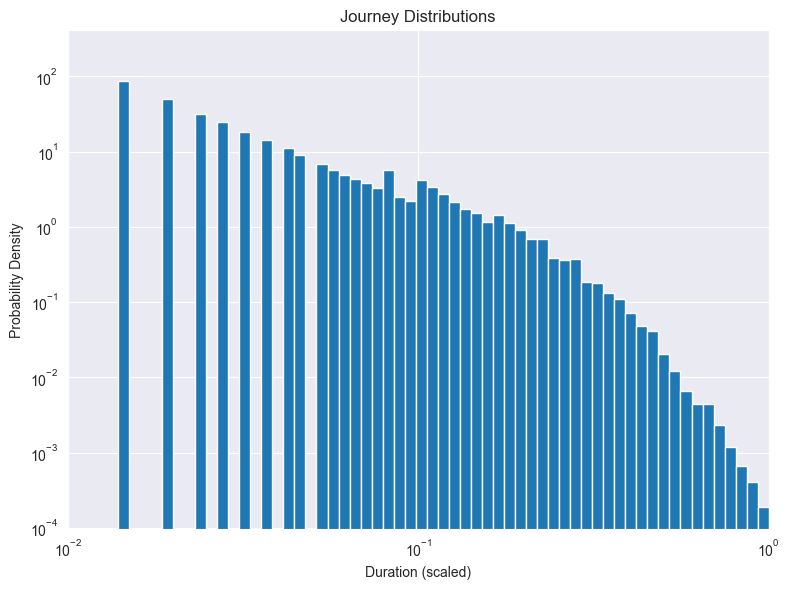

In [16]:
scaler = MinMaxScaler()
durations = np.asarray(durations)
durations = scaler.fit_transform(durations.reshape(-1, 1)).flatten()
durations = durations[durations > 0]


res = check_distribution_type(durations)
alpha = res[2][0]
loc   = res[2][1]
scale = res[2][2]
rv = powerlaw(a=alpha, loc=loc, scale=scale)


num_bins = 75  # adjust for resolution
log_bins = np.logspace(np.log10(durations.min()), np.log10(durations.max()), num_bins)

# --- 4) Create histogram with log bins, normalized to density
fig, ax = plt.subplots(figsize=(8, 6))
counts, bins, _ = ax.hist(
    durations,
    bins=log_bins,
    density=True   # normalize to probability density
)

# Overlay the PDF (this looks awful due to outliers)
# x = np.logspace(np.log10(durations.min()), np.log10(durations.max()), 50)
# pdf = rv.pdf(x)
# ax.plot(x, pdf, 'r-', label=f'Power-law fit (α={alpha:.4f})')
# ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Journey Distributions")
ax.set_xlabel("Duration (scaled)")
ax.set_ylabel("Probability Density")

plt.xlim(0.01,1)
plt.tight_layout()
plt.show()